# CM4044 Mini Project 2

#### Done by: Benjamin Chan (U1940715L), Carl Neo Dun Qi (U1940041G), Chia Yee Sheun (U1940627E)

# 1. Import Dataset and Checking

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw
from rdkit.Chem import Kekulize
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.EState import Fingerprinter
#----------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
#----------------------------------------------------
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF
#----------------------------------------------------
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline 
#---------------------------------------------------------------

In [2]:
dataset = pd.read_csv('Melting Point dataset_edited.csv', dtype={'smiles': str})
dataset.head(5)

,key,name,smiles,mpC,csid,link,source,count,min,max,range
0,27956,cyclobutylmethane,C1(CCC1)C,-161.51,11232,http://pubs.acs.org/doi/abs/10.1021/ja01142a048,Lemaire HP; Livingston RL Journal of the Ameri...,2,-161.51,-161.5,0.01
1,16005,Nitrogen oxide,[O-][N+]#N,-90.80,923,http://msds.chem.ox.ac.uk/,academic website,2,-90.81,-90.8,0.01
2,16127,Sulfuryl difluoride,FS(F)(=O)=O,-135.80,16647,http://msds.chem.ox.ac.uk/,academic website,2,-135.82,-135.8,0.02
3,17138,disopyramide,CC(C)N(CCC(c1ccccn1)(c2ccccc2)C(N)=O)C(C)C,94.80,3002,http://dx.doi.org/10.1021/ci700307p,Hughes LD; Palmer DS; Nigsch F and Mitchell JB...,2,94.75,94.8,0.05
4,15628,Bromine,BrBr,-7.20,22817,http://msds.chem.ox.ac.uk/,academic website,2,-7.25,-7.2,0.05


In [3]:
dataset.columns

Index(['key', 'name', 'smiles', 'mpC', 'csid', 'link', 'source', 'count',
       'min', 'max', 'range'],
      dtype='object')

In [4]:
dataset_drop = dataset.drop(['key', 'name', 'csid', 'link', 'source', 'count','min', 'max', 'range'],axis=1)
dataset_drop

,smiles,mpC
0,C1(CCC1)C,-161.51
1,[O-][N+]#N,-90.80
2,FS(F)(=O)=O,-135.80
3,CC(C)N(CCC(c1ccccn1)(c2ccccc2)C(N)=O)C(C)C,94.80
4,BrBr,-7.20
...,...,...
3020,C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],240.00
3021,C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O,275.00
3022,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CCC4=C3...,176.00
3023,C1=C(C=C(C(=C1Cl)O)Cl)Cl,65.00


In [5]:
dataset_drop.isna().sum()

smiles    0
mpC       0
dtype: int64

In [6]:
dataset_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  3025 non-null   object 
 1   mpC     3025 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.4+ KB


In [7]:
dataset_drop.describe()

,mpC
count,3025.000000
mean,62.254496
std,95.663463
min,-188.000000
25%,5.000000
50%,63.000000
75%,129.000000
max,438.000000


# 2. Dataset Cleaning 

## 2.1 Generate Mol from SMILEs 

In [8]:
from rdkit.Chem.rdmolops import FastFindRings
from rdkit.Chem import Kekulize

mol_list = []
for smiles in dataset_drop['smiles']: 
    mol = Chem.MolFromSmiles(smiles,False)
    #mol.UpdatePropertyCache(strict=False)
    #FastFindRings(mol)
        
    mol_list.append(mol)
    
    

mol_list



 ...]

In [9]:
dataset_drop['mol']= mol_list
dataset_clean = dataset_drop
dataset_clean

,smiles,mpC,mol
0,C1(CCC1)C,-161.51,<rdkit.Chem.rdchem.Mol object at 0x7f760b3fac10>
1,[O-][N+]#N,-90.80,<rdkit.Chem.rdchem.Mol object at 0x7f760b3b15d0>
2,FS(F)(=O)=O,-135.80,<rdkit.Chem.rdchem.Mol object at 0x7f760b3b1ee0>
3,CC(C)N(CCC(c1ccccn1)(c2ccccc2)C(N)=O)C(C)C,94.80,<rdkit.Chem.rdchem.Mol object at 0x7f760b3b1ad0>
4,BrBr,-7.20,<rdkit.Chem.rdchem.Mol object at 0x7f760b3b1f30>
...,...,...,...
3020,C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],240.00,<rdkit.Chem.rdchem.Mol object at 0x7f760b37d3a0>
3021,C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O,275.00,<rdkit.Chem.rdchem.Mol object at 0x7f760b37d3f0>
3022,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CCC4=C3...,176.00,<rdkit.Chem.rdchem.Mol object at 0x7f760b37d440>
3023,C1=C(C=C(C(=C1Cl)O)Cl)Cl,65.00,<rdkit.Chem.rdchem.Mol object at 0x7f760b37d490>


## 2.2 Generating Canonical Smiles

In [10]:
#There might be one or more valid SMILES that can represent one compound

def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] 
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [11]:
Canon_SMILES = canonical_smiles(dataset_clean.smiles)
len(Canon_SMILES)

3025

## 2.3 Dataset inspection 

In [12]:
#Check for any duplicate compound
duplicates_smiles = dataset_drop[dataset_clean['smiles'].duplicated()]['smiles'].values
len(duplicates_smiles)

0

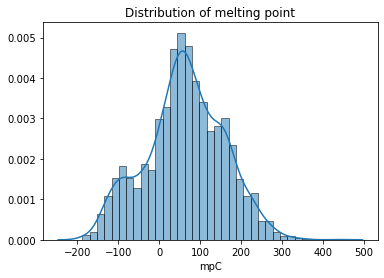

In [13]:
#variation in data distribution
sns.distplot(dataset_clean.mpC, bins=35, hist_kws={"rwidth":1.5,'edgecolor':'black', 'alpha':0.5})
plt.title('Distribution of melting point')
plt.show()

In [14]:
#chceking melting point data
dataset_clean.mpC.describe()

count    3025.000000
mean       62.254496
std        95.663463
min      -188.000000
25%         5.000000
50%        63.000000
75%       129.000000
max       438.000000
Name: mpC, dtype: float64

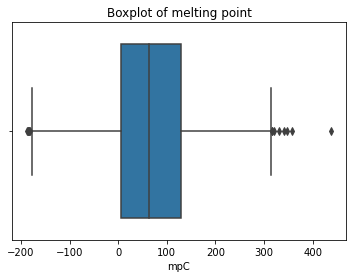

In [15]:
#Boxplot
sns.boxplot(dataset_clean.mpC)
plt.title('Boxplot of melting point')
plt.show()

## 2.4 Generating Descriptors

## 2.4.1 General molecular descriptors-about 200 molecular descriptors

In [16]:
def get_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors = []
    for mol in mols:
        #add hydrogens to molecules
        mol = Chem.AddHs(mol)
        #Calculate all 200 descriptors for every molecules
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Call function
Mol_descriptors,desc_names = get_descriptors(dataset_clean['smiles'])

In [17]:
dataset_200_desc = pd.DataFrame(Mol_descriptors,columns=desc_names)
dataset_200_desc

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,7.421875,-3.216667,7.421875,2.976042,0.407445,70.135,60.055,70.078250,30,0,...,0,0,0,0,0,0,0,0,0,0
1,8.111111,1.250000,8.111111,1.250000,0.290505,44.013,44.013,44.001063,16,0,...,0,0,0,0,0,0,0,0,0,0
2,9.993056,-5.666667,9.993056,5.666667,0.408382,102.061,102.061,101.958707,32,0,...,0,0,0,0,0,0,0,0,0,0
3,14.399396,-5.380155,14.399396,1.175727,0.802071,339.483,310.251,339.231063,134,0,...,0,0,0,0,0,0,0,0,0,0
4,2.750000,2.750000,2.750000,2.750000,0.505078,159.808,159.808,157.836674,14,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,11.054448,-1.405650,11.054448,0.805000,0.531152,167.120,162.080,167.021858,62,0,...,0,0,0,0,0,0,0,0,0,0
3021,12.811947,-3.822371,12.811947,0.360347,0.723359,258.233,248.153,258.064057,96,0,...,0,0,0,0,0,0,0,0,0,0
3022,9.518317,-4.835957,9.518317,1.216090,0.757170,272.388,248.196,272.177630,108,0,...,0,0,0,0,0,0,0,0,0,0
3023,7.319877,-0.263904,7.319877,0.156667,0.676128,197.448,194.424,195.924948,54,0,...,0,0,0,0,0,0,0,0,0,0


## 2.4.2 Remove highly Correlated Features

In [18]:
def remove_corr(descriptors):
    #calculate correlation
    correlated_matrix = descriptors.corr().abs()
    
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape), k=1).astype(np.bool))
    
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]
    print(to_drop)
    
    drop_correlated_desc = descriptors.drop(columns=to_drop, axis=1)
    return drop_correlated_desc
    

In [19]:
descriptors_new = remove_corr(dataset_200_desc)
descriptors_new

['MaxAbsEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'Kappa1', 'Kappa2', 'LabuteASA', 'PEOE_VSA6', 'PEOE_VSA8', 'SMR_VSA1', 'SMR_VSA5', 'SMR_VSA7', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA5', 'SlogP_VSA6', 'EState_VSA1', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState6', 'VSA_EState7', 'FractionCSP3', 'HeavyAtomCount', 'NOCount', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR', 'fr_Ar_N', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCO

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,7.421875,-3.216667,2.976042,0.407445,70.135,0,0.029985,1.600000,-7.922353e-02,-0.244573,...,0,0,0,0,0,0,0,0,0,0
1,8.111111,1.250000,1.250000,0.290505,44.013,0,0.236827,2.000000,1.643563e+01,13.222479,...,0,0,0,0,0,0,0,0,0,0
2,9.993056,-5.666667,5.666667,0.408382,102.061,0,0.475731,1.200000,3.227906e+01,15.935513,...,0,0,0,0,0,0,0,0,0,0
3,14.399396,-5.380155,1.175727,0.802071,339.483,0,0.233716,0.960000,2.018850e-16,-0.249141,...,0,0,0,0,0,0,0,0,0,0
4,2.750000,2.750000,2.750000,0.505078,159.808,0,0.000000,1.000000,8.090400e+01,78.904000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,11.054448,-1.405650,0.805000,0.531152,167.120,0,0.335187,1.500000,1.360028e+01,-0.089321,...,0,0,0,0,0,0,0,0,0,0
3021,12.811947,-3.822371,0.360347,0.723359,258.233,0,0.261799,0.947368,1.279166e+01,-0.180268,...,0,0,0,0,0,0,0,0,0,0
3022,9.518317,-4.835957,1.216090,0.757170,272.388,0,0.293092,1.050000,-2.169150e-16,-0.243759,...,0,0,0,0,0,0,0,0,0,0
3023,7.319877,-0.263904,0.156667,0.676128,197.448,0,0.293256,1.100000,1.631174e+01,-0.082906,...,0,0,0,0,0,0,0,0,0,0


## 2.4.3 Remove low variance features

In [20]:
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(data)
    return data[data.columns[selection.get_support(indices=True)]]

X = remove_low_variance(descriptors_new, threshold=0.1)
X


,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BalabanJ,HallKierAlpha,...,fr_amide,fr_aniline,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_methoxy,fr_nitro,fr_para_hydroxylation
0,7.421875,-3.216667,2.976042,70.135,1.600000,-7.922353e-02,-0.244573,-5.868918e-01,3.362621,0.00,...,0,0,0,0,0,0,0,0,0,0
1,8.111111,1.250000,1.250000,44.013,2.000000,1.643563e+01,13.222479,1.185171e+00,2.475534,-0.78,...,0,0,0,0,0,0,0,0,0,0
2,9.993056,-5.666667,5.666667,102.061,1.200000,3.227906e+01,15.935513,1.943017e+00,4.062942,-0.19,...,0,0,0,0,0,2,0,0,0,0
3,14.399396,-5.380155,1.175727,339.483,0.960000,2.018850e-16,-0.249141,-2.329742e-16,3.821721,-2.20,...,1,0,0,0,0,0,0,0,0,0
4,2.750000,2.750000,2.750000,159.808,1.000000,8.090400e+01,78.904000,1.000000e+00,1.000000,0.96,...,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,11.054448,-1.405650,0.805000,167.120,1.500000,1.360028e+01,-0.089321,6.670566e-01,3.701245,-1.91,...,0,0,0,0,0,0,0,0,1,0
3021,12.811947,-3.822371,0.360347,258.233,0.947368,1.279166e+01,-0.180268,5.121673e-01,2.334673,-2.50,...,4,0,1,0,0,0,0,0,0,0
3022,9.518317,-4.835957,1.216090,272.388,1.050000,-2.169150e-16,-0.243759,-6.893588e-17,2.547205,-1.02,...,0,0,5,0,0,0,0,0,0,0
3023,7.319877,-0.263904,0.156667,197.448,1.100000,1.631174e+01,-0.082906,8.718441e-01,3.563758,-0.11,...,0,0,0,0,0,3,0,0,0,0


In [21]:
dataset_71_col = pd.concat([X, dataset_clean['mpC']], axis=1)
dataset_71_col

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BalabanJ,HallKierAlpha,...,fr_aniline,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_methoxy,fr_nitro,fr_para_hydroxylation,mpC
0,7.421875,-3.216667,2.976042,70.135,1.600000,-7.922353e-02,-0.244573,-5.868918e-01,3.362621,0.00,...,0,0,0,0,0,0,0,0,0,-161.51
1,8.111111,1.250000,1.250000,44.013,2.000000,1.643563e+01,13.222479,1.185171e+00,2.475534,-0.78,...,0,0,0,0,0,0,0,0,0,-90.80
2,9.993056,-5.666667,5.666667,102.061,1.200000,3.227906e+01,15.935513,1.943017e+00,4.062942,-0.19,...,0,0,0,0,2,0,0,0,0,-135.80
3,14.399396,-5.380155,1.175727,339.483,0.960000,2.018850e-16,-0.249141,-2.329742e-16,3.821721,-2.20,...,0,0,0,0,0,0,0,0,0,94.80
4,2.750000,2.750000,2.750000,159.808,1.000000,8.090400e+01,78.904000,1.000000e+00,1.000000,0.96,...,0,0,0,0,2,0,0,0,0,-7.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,11.054448,-1.405650,0.805000,167.120,1.500000,1.360028e+01,-0.089321,6.670566e-01,3.701245,-1.91,...,0,0,0,0,0,0,0,1,0,240.00
3021,12.811947,-3.822371,0.360347,258.233,0.947368,1.279166e+01,-0.180268,5.121673e-01,2.334673,-2.50,...,0,1,0,0,0,0,0,0,0,275.00
3022,9.518317,-4.835957,1.216090,272.388,1.050000,-2.169150e-16,-0.243759,-6.893588e-17,2.547205,-1.02,...,0,5,0,0,0,0,0,0,0,176.00
3023,7.319877,-0.263904,0.156667,197.448,1.100000,1.631174e+01,-0.082906,8.718441e-01,3.563758,-0.11,...,0,0,0,0,3,0,0,0,0,65.00


## 2.4.4 Remove Outliers

In [22]:
from scipy import stats
dataset_71_new = dataset_71_col[(np.abs(stats.zscore(dataset_71_col)) <3).all(axis=1)]

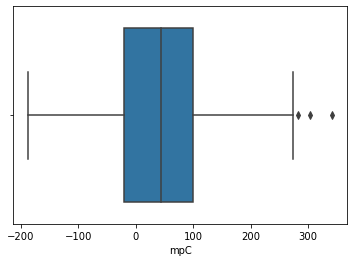

In [23]:
sns.boxplot(dataset_71_new.mpC)

In [24]:
dataset_71_new

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BalabanJ,HallKierAlpha,...,fr_aniline,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_methoxy,fr_nitro,fr_para_hydroxylation,mpC
0,7.421875,-3.216667,2.976042,70.135,1.600000,-7.922353e-02,-0.244573,-5.868918e-01,3.362621,0.00,...,0,0,0,0,0,0,0,0,0,-161.51
13,11.353143,-3.742130,2.212384,116.160,1.625000,-6.816978e-17,-0.249186,-1.606831e-16,5.382309,-0.53,...,0,0,1,1,0,0,0,0,0,-76.00
14,10.790556,-3.119097,1.246644,100.117,1.857143,8.833847e-16,-0.245934,-2.713218e-17,4.927954,-0.79,...,0,0,1,1,0,0,0,0,0,-93.00
15,10.087102,-3.364375,1.830440,88.106,2.166667,-1.082792e-15,-0.247532,-1.270598e-01,4.969829,-0.53,...,0,0,0,1,0,0,0,0,0,-93.00
17,7.892824,-3.348660,1.044213,134.222,0.900000,-1.512647e-15,-0.249097,-1.252736e-02,4.001790,-0.78,...,0,0,0,0,0,0,0,0,0,-84.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3013,7.884838,-3.338568,0.817883,132.206,0.900000,-2.144007e-16,-0.189060,-1.281932e-16,3.110020,-0.78,...,0,1,0,0,0,0,0,0,0,-31.00
3014,8.225105,-3.749908,0.907597,212.292,0.812500,2.954086e-15,-0.244322,-5.568833e-17,3.398988,-1.76,...,0,0,0,0,0,0,0,0,0,71.50
3015,7.454005,-2.717901,0.389324,142.585,1.555556,1.092320e+01,-0.164922,-1.163257e-16,3.645795,-0.53,...,0,0,0,0,1,0,0,0,0,71.00
3016,10.700754,-1.049116,0.650278,149.149,1.454545,1.167752e+01,-0.163664,3.448385e-02,3.853936,-1.64,...,0,0,0,0,0,0,0,1,0,-5.00


# 3. Features Selection - Recursive Feature Elimination (Decision Tree)

In [31]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import KFold

In [32]:
X = dataset_71_new.drop(['mpC'], axis=1) # features
y = dataset_71_new['mpC']

In [33]:
#Split Training and Test set into 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Scale train and test sets with standard scaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [34]:
#Using RFE Class 
#However, the optimal number of features is not known
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=10)
rfe.fit(X_train_std, y_train)

for i, col in zip(range(X.shape[1]), X.columns):
    print(f"{col} selected={rfe.support_[i]} rank={rfe.ranking_[i]}")

MaxEStateIndex selected=True rank=1
MinEStateIndex selected=False rank=5
MinAbsEStateIndex selected=False rank=8
MolWt selected=True rank=1
FpDensityMorgan1 selected=True rank=1
BCUT2D_MWHI selected=True rank=1
BCUT2D_MWLOW selected=True rank=1
BCUT2D_CHGHI selected=False rank=7
BalabanJ selected=True rank=1
HallKierAlpha selected=True rank=1
Ipc selected=False rank=36
Kappa3 selected=False rank=9
PEOE_VSA1 selected=False rank=24
PEOE_VSA10 selected=False rank=16
PEOE_VSA11 selected=False rank=34
PEOE_VSA12 selected=False rank=28
PEOE_VSA13 selected=False rank=21
PEOE_VSA14 selected=False rank=29
PEOE_VSA2 selected=False rank=40
PEOE_VSA3 selected=False rank=33
PEOE_VSA4 selected=False rank=47
PEOE_VSA5 selected=False rank=31
PEOE_VSA7 selected=False rank=4
PEOE_VSA9 selected=False rank=10
SMR_VSA10 selected=False rank=3
SMR_VSA2 selected=False rank=15
SMR_VSA3 selected=False rank=42
SMR_VSA4 selected=False rank=19
SMR_VSA6 selected=False rank=22
SMR_VSA9 selected=False rank=23
SlogP_V

In [35]:
#Instead Using RFECV class to find the optimal number of features to select using DecsionTreeRegressor
model = DecisionTreeRegressor(random_state=42)
dtr_cv = RFECV(estimator=model, step=1,cv=5, scoring='r2')
dtr_cv = dtr_cv.fit(X_train_std, y_train)

print("The optimal number of features:", dtr_cv.n_features_)
print("Best features:", X_train.columns[dtr_cv.support_])

#Shows that the optimal number of features to select out of the 71 is 41
#Shows the features to select 

The optimal number of features: 41
Best features: Index(['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'MolWt',
       'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BalabanJ', 'HallKierAlpha', 'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA7',
       'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA4', 'SMR_VSA6',
       'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA3', 'SlogP_VSA7', 'SlogP_VSA8',
       'TPSA', 'EState_VSA10', 'EState_VSA2', 'EState_VSA8', 'VSA_EState3',
       'VSA_EState4', 'VSA_EState5', 'VSA_EState8', 'NHOHCount', 'fr_NH0',
       'fr_NH1', 'fr_amide', 'fr_ether'],
      dtype='object')


## 3.1 New Selected Features for Decision Tree Regressor Prediction

In [28]:
X_dt = X[['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'MolWt',
       'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BalabanJ', 'HallKierAlpha', 'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA7',
       'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA4', 'SMR_VSA6',
       'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA3', 'SlogP_VSA7', 'SlogP_VSA8',
       'TPSA', 'EState_VSA10', 'EState_VSA2', 'EState_VSA8', 'VSA_EState3',
       'VSA_EState4', 'VSA_EState5', 'VSA_EState8', 'NHOHCount', 'fr_NH0',
       'fr_NH1', 'fr_amide', 'fr_ether']]

y = dataset_71_new['mpC']
        

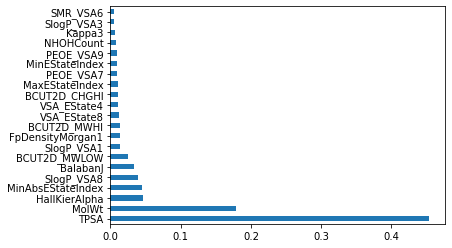

In [29]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_dt,y)
feat_importances = pd.Series(dtr.feature_importances_, index=X_dt.columns)
feat_importances.nlargest(21).plot(kind='barh')

## 3.1.1 Cross Validation for Decision Tree Regressor

In [30]:
#Decision Tree Regressor
dtr_cv= DecisionTreeRegressor(random_state=42)
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = np.mean(cross_val_score(dtr_cv, X_dt, y, scoring='r2', cv=folds))
print('CV for Decision Tree Regressor:',scores)

CV for Decision Tree Regressor: 0.6613633160834369


In [31]:
#Split Training and Test set into 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X_dt, y, test_size=0.25, random_state=42)

#Scale train and test sets with standard scaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [32]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train_std,y_train)
dtr_pred=dtr.predict(X_test_std)

rmse=np.sqrt(mean_squared_error(y_test, dtr_pred))
r2 = r2_score(y_test, dtr_pred)
mae = mean_absolute_error(y_test, dtr_pred)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)


Root Mean Squared Error: 59.87798166345731
Mean Absolute Error: 44.08444168734491
R2 Score: 0.562047921389845


## 3.2 Hyperparameter Tuning - Decison Tree Regressor 

In [33]:
def get_mae(max_leaf_nodes, X_train_std,X_test_std, y_train, y_test):
    dtr_tune = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=42)
    dtr_tune.fit(X_train_std, y_train)
    preds_test = dtr_tune.predict(X_test_std)
    mae = mean_absolute_error(y_test, preds_test)
    return(mae)

In [34]:
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 250, 500, 5000, 10000]:
    my_mae = get_mae(max_leaf_nodes,X_train_std, X_test_std, y_train, y_test)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  49
Max leaf nodes: 50  		 Mean Absolute Error:  38
Max leaf nodes: 250  		 Mean Absolute Error:  40
Max leaf nodes: 500  		 Mean Absolute Error:  41
Max leaf nodes: 5000  		 Mean Absolute Error:  42
Max leaf nodes: 10000  		 Mean Absolute Error:  42


In [35]:
#After Tuning tree depth 

dtr_tune = DecisionTreeRegressor(max_leaf_nodes=50, random_state=42)
dtr_tune.fit(X_train_std, y_train)
preds_test = dtr_tune.predict(X_test_std)

rmse=np.sqrt(mean_squared_error(y_test, preds_test))
r2 = r2_score(y_test, preds_test)
mae = mean_absolute_error(y_test, preds_test)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)

Root Mean Squared Error: 52.142799383618296
Mean Absolute Error: 38.59156344734721
R2 Score: 0.6678907492867816


## 3.3 Decison Tree Regressor Performance

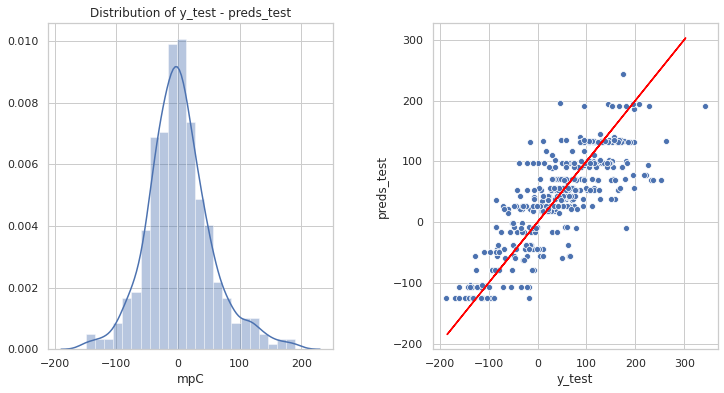

In [36]:
sns.set(style='whitegrid')

fig, axs = plt.subplots(1,2, figsize=(12, 6))

g = sns.distplot(y_test-preds_test, ax=axs[0])
g.set(title='Distribution of y_test - preds_test')
plt.plot(y_train,y_train, color='red')


h = sns.scatterplot(y_test, preds_test)
h.set(xlabel='y_test')
h.set(ylabel='preds_test')

fig.subplots_adjust(hspace=0.2, wspace=0.35)

plt.show()

In [37]:
dtr_pred = pd.DataFrame({'Actual Value':y_test, 'Predicted Value':preds_test, 'Difference':y_test-preds_test})
dtr_pred.sample(10)

,Actual Value,Predicted Value,Difference
194,-48.0,-56.309302,8.309302
2521,88.0,70.629310,17.370690
2185,-9.0,97.692308,-106.692308
798,24.0,91.309524,-67.309524
2217,142.0,97.692308,44.307692
2966,150.0,68.454545,81.545455
2924,145.0,97.692308,47.307692
252,-45.0,-45.100000,0.100000
165,53.0,51.997059,1.002941
2189,-43.0,51.997059,-94.997059


# 4. Features Selection - Recursive Feature Elimination (ExtraTreesRegression)

In [42]:
X = dataset_71_new.drop(['mpC'], axis=1) # features
y = dataset_71_new['mpC']

In [43]:
#Split Training and Test set into 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Scale train and test sets with standard scaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [44]:
#Using RFECV to find the optimal number of features to select using ExtraTreesRegressor
model = ExtraTreesRegressor(random_state=42)
etr_cv = RFECV(estimator=model, step=1,cv=5, scoring='r2')
etr_cv = etr_cv.fit(X_train_std, y_train)

print("The optimal number of features:", etr_cv.n_features_)
print("Best features:", X_train.columns[etr_cv.support_])

#Shows that the optimal number of features to select out of the 102 is 30 
#Shows the features to select 

The optimal number of features: 30
Best features: Index(['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'MolWt',
       'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BalabanJ', 'HallKierAlpha', 'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA13', 'PEOE_VSA3', 'PEOE_VSA7', 'PEOE_VSA9',
       'SMR_VSA10', 'SlogP_VSA3', 'SlogP_VSA8', 'TPSA', 'EState_VSA10',
       'VSA_EState3', 'VSA_EState4', 'VSA_EState8', 'NHOHCount', 'fr_NH0',
       'fr_amide', 'fr_ether'],
      dtype='object')


## 4.1 New Selected Features for ExtraTreesRegressor

In [45]:
X_etr = X[['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'MolWt',
       'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BalabanJ', 'HallKierAlpha', 'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA13', 'PEOE_VSA3', 'PEOE_VSA7', 'PEOE_VSA9',
       'SMR_VSA10', 'SlogP_VSA3', 'SlogP_VSA8', 'TPSA', 'EState_VSA10',
       'VSA_EState3', 'VSA_EState4', 'VSA_EState8', 'NHOHCount', 'fr_NH0',
       'fr_amide', 'fr_ether']]

y = dataset_71_new['mpC']

Feature: 0, Score: 0.02118
Feature: 1, Score: 0.01144
Feature: 2, Score: 0.01800
Feature: 3, Score: 0.07739
Feature: 4, Score: 0.02037
Feature: 5, Score: 0.26905
Feature: 6, Score: 0.01220
Feature: 7, Score: 0.01487
Feature: 8, Score: 0.02001
Feature: 9, Score: 0.07074
Feature: 10, Score: 0.01080
Feature: 11, Score: 0.02346
Feature: 12, Score: 0.01018
Feature: 13, Score: 0.00785
Feature: 14, Score: 0.01860
Feature: 15, Score: 0.01089
Feature: 16, Score: 0.01538
Feature: 17, Score: 0.00991
Feature: 18, Score: 0.01304
Feature: 19, Score: 0.00733
Feature: 20, Score: 0.01391
Feature: 21, Score: 0.10973
Feature: 22, Score: 0.00924
Feature: 23, Score: 0.00850
Feature: 24, Score: 0.01293
Feature: 25, Score: 0.00707
Feature: 26, Score: 0.14476
Feature: 27, Score: 0.01222
Feature: 28, Score: 0.01188
Feature: 29, Score: 0.00710


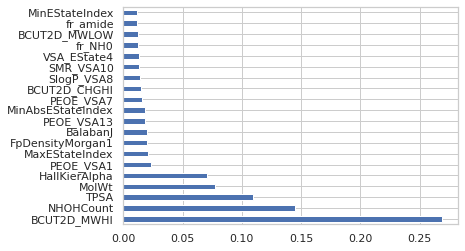

In [46]:
etr_feature = ExtraTreesRegressor(random_state=42)
etr_feature.fit(X_etr,y)
importance = etr_feature.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feat_importances = pd.Series(etr_feature.feature_importances_, index=X_etr.columns)
feat_importances.nlargest(20).plot(kind='barh')

## 4.2 Cross_validation Extra Trees Regressor

In [47]:
etr_cv= ExtraTreesRegressor(random_state=42)
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = np.mean(cross_val_score(etr_cv, X_etr, y, scoring='r2', cv=folds))
print('CV score for XGBoost:',scores) 

CV score for XGBoost: 0.8357329001141256


In [48]:
#Split Training and Test set into 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X_etr, y, test_size=0.25, random_state=42)

#Scale train and test sets with standard scaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [49]:
etr = ExtraTreesRegressor(random_state=42)
etr.fit(X_train_std,y_train)
etr_pred=etr.predict(X_test_std)

rmse=np.sqrt(mean_squared_error(y_test, etr_pred))
r2 = r2_score(y_test, etr_pred)
mae = mean_absolute_error(y_test, etr_pred)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)

Root Mean Squared Error: 36.563222403699356
Mean Absolute Error: 27.140239205955336
R2 Score: 0.8367018689111765


## 4.3 Hyperparameter Tuning (Extra Trees Regressor)

In [51]:
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_leaf':[1,2,3],}

In [52]:
xt_tune = ExtraTreesRegressor(random_state=42)
xt_cv=GridSearchCV(estimator=xt_tune,param_grid=param_grid,cv=5,verbose=3)
xt_cv.fit(X_train_std,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] min_samples_leaf=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. min_samples_leaf=1, score=0.845, total=   0.5s
[CV] min_samples_leaf=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .................. min_samples_leaf=1, score=0.824, total=   0.5s
[CV] min_samples_leaf=1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] .................. min_samples_leaf=1, score=0.833, total=   0.5s
[CV] min_samples_leaf=1 ..............................................
[CV] .................. min_samples_leaf=1, score=0.830, total=   0.5s
[CV] min_samples_leaf=1 ..............................................
[CV] .................. min_samples_leaf=1, score=0.810, total=   0.5s
[CV] min_samples_leaf=2 ..............................................
[CV] .................. min_samples_leaf=2, score=0.848, total=   0.4s
[CV] min_samples_leaf=2 ..............................................
[CV] .................. min_samples_leaf=2, score=0.825, total=   0.4s
[CV] min_samples_leaf=2 ..............................................
[CV] .................. min_samples_leaf=2, score=0.835, total=   0.4s
[CV] min_samples_leaf=2 ..............................................
[CV] .................. min_samples_leaf=2, score=0.832, total=   0.4s
[CV] min_samples_leaf=2 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    6.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=42,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param

In [54]:
print('Grid search best parameters:',xt_cv.best_params_)
print('Grid search best score:',xt_cv.best_score_)

Grid search best parameters: {'min_samples_leaf': 3}
Grid search best score: 0.829949127242038


In [60]:
xt_best = xt_cv.best_estimator_

xt_best.fit(X_train_std,y_train)
pred_tuned=xt_best.predict(X_test_std)

rmse=np.sqrt(mean_squared_error(y_test, pred_tuned))
r2 = r2_score(y_test, pred_tuned)
mae = mean_absolute_error(y_test, pred_tuned)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)

Root Mean Squared Error: 36.47336274972229
Mean Absolute Error: 27.45928494347946
R2 Score: 0.8375035423365098


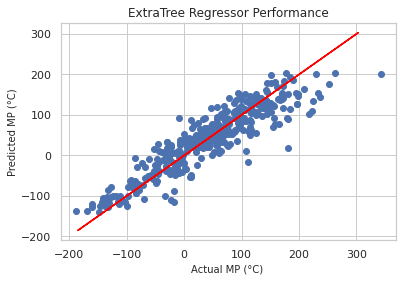

In [61]:
# scatterplot of actual vs. pred

# Validation Results
plt.scatter(x=y_test, y=pred_tuned) # first row, second entry (right top)
plt.xlabel("Actual MP (°C) ", fontsize=10)
plt.ylabel("Predicted MP (°C)",  fontsize=10)
plt.title("ExtraTree Regressor Performance")
plt.plot(y_train,y_train, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

# 5. Features Selection - Recursive Feature Elimination (XGboost)

In [149]:
!pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [44]:
X = dataset_71_new.drop(['mpC'], axis=1) # features
y = dataset_71_new['mpC']

In [45]:
#Split Training and Test set into 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Scale train and test sets with standard scaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [50]:
#Using RFECV to find the optimal number of features to select using XGBoostRegressor
model = XGBRegressor(random_state=42)
xgb_cv = RFECV(estimator=model, step=1,cv=5, scoring='r2')
xgb_cv = xgb_cv.fit(X_train_std, y_train)

print("The optimal number of features:", xgb_cv.n_features_)
print("Best features:", X_train.columns[xgb_cv.support_])

#Shows that the optimal number of features to select out of the 102 is 45
#Shows the features to select 

The optimal number of features: 45
Best features: Index(['MinAbsEStateIndex', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_MWHI',
       'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BalabanJ', 'HallKierAlpha', 'Ipc',
       'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA13',
       'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA7', 'PEOE_VSA9',
       'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA6',
       'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA7',
       'SlogP_VSA8', 'TPSA', 'EState_VSA10', 'EState_VSA2', 'EState_VSA8',
       'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState8', 'NHOHCount',
       'fr_Ar_OH', 'fr_NH1', 'fr_amide', 'fr_bicyclic', 'fr_ether',
       'fr_para_hydroxylation'],
      dtype='object')


## 5.1 New Selected Features for XGBoost Prediction

In [150]:
X_xgb = X[['MinAbsEStateIndex', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_MWHI',
       'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BalabanJ', 'HallKierAlpha', 'Ipc',
       'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA13',
       'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA7', 'PEOE_VSA9',
       'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA6',
       'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA7',
       'SlogP_VSA8', 'TPSA', 'EState_VSA10', 'EState_VSA2', 'EState_VSA8',
       'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState8', 'NHOHCount',
       'fr_Ar_OH', 'fr_NH1', 'fr_amide', 'fr_bicyclic', 'fr_ether',
       'fr_para_hydroxylation']]

y = dataset_71_new['mpC']

Feature: 0, Score: 0.00351
Feature: 1, Score: 0.03996
Feature: 2, Score: 0.00387
Feature: 3, Score: 0.02491
Feature: 4, Score: 0.00535
Feature: 5, Score: 0.00737
Feature: 6, Score: 0.00748
Feature: 7, Score: 0.02708
Feature: 8, Score: 0.00794
Feature: 9, Score: 0.00243
Feature: 10, Score: 0.04040
Feature: 11, Score: 0.00356
Feature: 12, Score: 0.00174
Feature: 13, Score: 0.00596
Feature: 14, Score: 0.01207
Feature: 15, Score: 0.00297
Feature: 16, Score: 0.00722
Feature: 17, Score: 0.00325
Feature: 18, Score: 0.00342
Feature: 19, Score: 0.00814
Feature: 20, Score: 0.00426
Feature: 21, Score: 0.00847
Feature: 22, Score: 0.00436
Feature: 23, Score: 0.00743
Feature: 24, Score: 0.02074
Feature: 25, Score: 0.00187
Feature: 26, Score: 0.00761
Feature: 27, Score: 0.00356
Feature: 28, Score: 0.00324
Feature: 29, Score: 0.03587
Feature: 30, Score: 0.35915
Feature: 31, Score: 0.00217
Feature: 32, Score: 0.00202
Feature: 33, Score: 0.00904
Feature: 34, Score: 0.00224
Feature: 35, Score: 0.00407
Fe

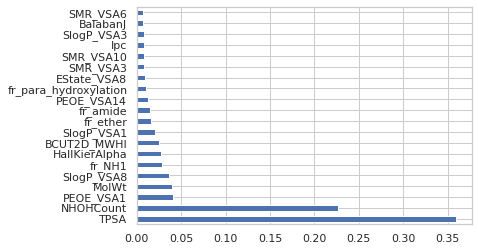

In [151]:
xgb_feature = XGBRegressor(random_state=42)
xgb_feature.fit(X_xgb,y)
importance = xgb_feature.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feat_importances = pd.Series(xgb_feature.feature_importances_, index=X_xgb.columns)
feat_importances.nlargest(20).plot(kind='barh')

## 5.1.1 Cross Validation for XGBoost

In [152]:
xgr_cv= xgb.XGBRegressor(random_state=42)
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = np.mean(cross_val_score(xgr_cv, X_xgb, y, scoring='r2', cv=folds))
print('CV score for XGBoost:',scores) 

CV score for XGBoost: 0.8400607630398526


In [153]:
#Split Training and Test set into 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X_xgb, y, test_size=0.25, random_state=42)

#Scale train and test sets with standard scaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [154]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_std,y_train)
xgb_pred=xgb.predict(X_test_std)

rmse=np.sqrt(mean_squared_error(y_test, xgb_pred))
r2 = r2_score(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)

Root Mean Squared Error: 39.509958008471905
Mean Absolute Error: 30.526222973958433
R2 Score: 0.8093198774952979


## 5.2 Hyperparameter Tuning - (XGboost)

In [50]:
from sklearn.model_selection import GridSearchCV

In [73]:
param={'n_estimators':[10,20,50,100,150,200],
      'max_depth':range(2,6),
      'eta':[0.01,0.1,0.15,0.2,0.25,0.3],
      'min_child_weight':[1, 2, 3]}

xgr_tune=XGBRegressor(random_state=42)
gs=GridSearchCV(estimator=xgr_tune,param_grid=param,cv=5,verbose=3)
gs.fit(X_train_std,y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10 ......
[CV]  eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10, score=-0.052, total=   0.0s
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10 ......
[CV]  eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10, score=0.025, total=   0.0s
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10 ......
[CV]  eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10, score=-0.069, total=   0.0s
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10, score=-0.052, total=   0.1s
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10 ......
[CV]  eta=0.01, max_depth=2, min_child_weight=1, n_estimators=10, score=-0.115, total=   0.0s
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=20 ......
[CV]  eta=0.01, max_depth=2, min_child_weight=1, n_estimators=20, score=0.065, total=   0.1s
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=20 ......
[CV]  eta=0.01, max_depth=2, min_child_weight=1, n_estimators=20, score=0.129, total=   0.1s
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=20 ......
[CV]  eta=0.01, max_depth=2, min_child_weight=1, n_estimators=20, score=0.042, total=   0.1s
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=20 ......
[CV]  eta=0.01, max_depth=2, min_child_weight=1, n_estimators=20, score=0.057, total=   0.1s
[CV] eta=0.01, max_depth=2, min_child_weight=1, n_estimators=20 ......
[CV]  eta=0.01

[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed: 13.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_...
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    predictor=None, random_state=42,
                                    reg_alpha=None, ...),
             iid='deprecat

In [74]:
print('Grid search best parameters:',gs.best_params_)
print('Grid search best score:',gs.best_score_)

Grid search best parameters: {'eta': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 150}
Grid search best score: 0.8442438101204586


In [155]:
#After Hyperparameter Tuning

xgr_tuned=XGBRegressor(eta=0.1,max_depth=4,n_estimators=150,min_child_weight=2, random_state=42)
xgr_tuned.fit(X_train_std,y_train)
pred_tuned=xgr_tuned.predict(X_test_std)

rmse=np.sqrt(mean_squared_error(y_test, pred_tuned))
r2 = r2_score(y_test, pred_tuned)
mae = mean_absolute_error(y_test, pred_tuned)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)

Root Mean Squared Error: 39.67620876379814
Mean Absolute Error: 31.05569038324557
R2 Score: 0.8077118064454225


## 5.3 XGBoost Performance

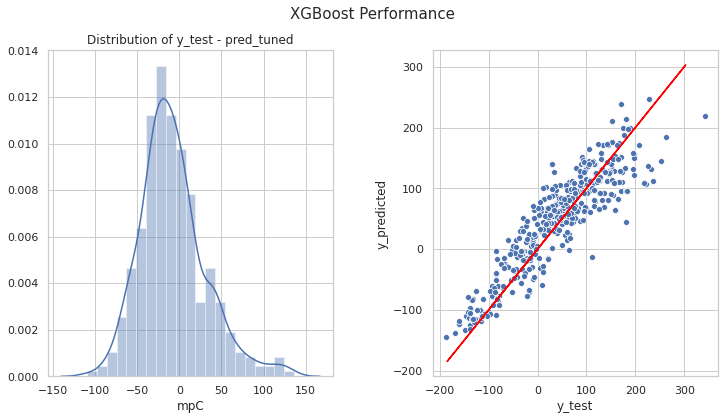

In [156]:
sns.set(style='whitegrid')

fig, axs = plt.subplots(1,2, figsize=(12, 6))

g = sns.distplot(y_test-pred_tuned, ax=axs[0])
g.set(title='Distribution of y_test - pred_tuned')
plt.plot(y_train,y_train, color='red')


h = sns.scatterplot(y_test,pred_tuned)
h.set(xlabel='y_test')
h.set(ylabel='y_predicted')

fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.suptitle('XGBoost Performance',fontsize=15)

plt.show()

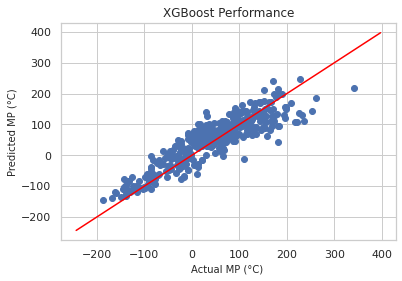

In [157]:
# scatterplot of actual vs. pred

# Validation Results
plt.scatter(x=y_test, y=pred_tuned) # first row, second entry (right top)
plt.xlabel("Actual MP (°C) ", fontsize=10)
plt.ylabel("Predicted MP (°C)",  fontsize=10)
plt.title("XGBoost Performance")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
plt.plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

# 6. Features Selection - Recursive Feature Elimination (Random Forest)

In [78]:
#Testin on RandomForestRegressor
X = dataset_71_new.drop(['mpC'], axis=1) # features
y = dataset_71_new['mpC']

In [79]:
#Split Training and Test set into 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Scale train and test sets with standard scaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [80]:
#Using RFECV to find the optimal number of features to select using RandomForestRegressor
model = RandomForestRegressor(random_state=42)
rfe_cv = RFECV(estimator=model, step=1,cv=5, scoring='r2')
rfe_cv = rfe_cv.fit(X_train_std, y_train)

print("The optimal number of features:", rfe_cv.n_features_)
print("Best features:", X_train.columns[rfe_cv.support_])

#Shows that the optimal number of features to select out of the 102 is 78 
#Shows the features to select 

The optimal number of features: 52
Best features: Index(['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'MolWt',
       'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BalabanJ', 'HallKierAlpha', 'Ipc', 'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2',
       'PEOE_VSA3', 'PEOE_VSA5', 'PEOE_VSA7', 'PEOE_VSA9', 'SMR_VSA10',
       'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA6', 'SMR_VSA9',
       'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA7',
       'SlogP_VSA8', 'TPSA', 'EState_VSA10', 'EState_VSA2', 'EState_VSA8',
       'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState8',
       'VSA_EState9', 'NHOHCount', 'fr_NH0', 'fr_NH1', 'fr_amide',
       'fr_bicyclic', 'fr_ether', 'fr_halogen', 'fr_para_hydroxylation'],
      dtype='object')


## 6.1 Selected Features for Random Forest Regressor

In [59]:
X_rfr = X[['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'MolWt',
       'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BalabanJ', 'HallKierAlpha', 'Ipc', 'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2',
       'PEOE_VSA3', 'PEOE_VSA5', 'PEOE_VSA7', 'PEOE_VSA9', 'SMR_VSA10',
       'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA6', 'SMR_VSA9',
       'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA7',
       'SlogP_VSA8', 'TPSA', 'EState_VSA10', 'EState_VSA2', 'EState_VSA8',
       'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState8',
       'VSA_EState9', 'NHOHCount', 'fr_NH0', 'fr_NH1', 'fr_amide',
       'fr_bicyclic', 'fr_ether', 'fr_halogen', 'fr_para_hydroxylation']]

y = dataset_71_new['mpC']

Feature: 0, Score: 0.01075
Feature: 1, Score: 0.00798
Feature: 2, Score: 0.03210
Feature: 3, Score: 0.16095
Feature: 4, Score: 0.01341
Feature: 5, Score: 0.03009
Feature: 6, Score: 0.02666
Feature: 7, Score: 0.01734
Feature: 8, Score: 0.03071
Feature: 9, Score: 0.09704
Feature: 10, Score: 0.01173
Feature: 11, Score: 0.00924
Feature: 12, Score: 0.00801
Feature: 13, Score: 0.00532
Feature: 14, Score: 0.00244
Feature: 15, Score: 0.00137
Feature: 16, Score: 0.00177
Feature: 17, Score: 0.00151
Feature: 18, Score: 0.00173
Feature: 19, Score: 0.00354
Feature: 20, Score: 0.00037
Feature: 21, Score: 0.00939
Feature: 22, Score: 0.00803
Feature: 23, Score: 0.01328
Feature: 24, Score: 0.00066
Feature: 25, Score: 0.00123
Feature: 26, Score: 0.00090
Feature: 27, Score: 0.00445
Feature: 28, Score: 0.00100
Feature: 29, Score: 0.00308
Feature: 30, Score: 0.00045
Feature: 31, Score: 0.00447
Feature: 32, Score: 0.00157
Feature: 33, Score: 0.00159
Feature: 34, Score: 0.01600
Feature: 35, Score: 0.38250
Fe

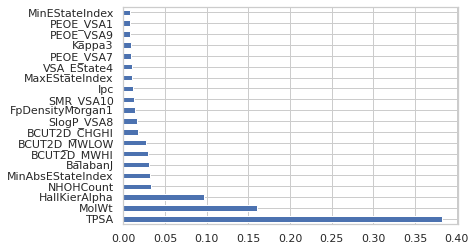

In [83]:
rfr_feature = RandomForestRegressor(random_state=42)
rfr_feature.fit(X_rfr,y)
importance = rfr_feature.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feat_importances = pd.Series(rfr_feature.feature_importances_, index=X_rfr.columns)
feat_importances.nlargest(20).plot(kind='barh')

## 6.1.1 Cross Validation for Random Forest Regressor

In [60]:
rfr_cv= RandomForestRegressor(random_state=42)
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = np.mean(cross_val_score(rfr_cv, X_rfr, y, scoring='r2', cv=folds))
print('CV score for Random Forest Regressor:',scores) 

CV score for Random Forest Regressor: 0.8452141689522253


In [61]:
#Split Training and Test set into 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X_rfr, y, test_size=0.25, random_state=42)

#Scale train and test sets with standard scaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [62]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_std,y_train)
rfr_pred=rfr.predict(X_test_std)

rmse=np.sqrt(mean_squared_error(y_test, rfr_pred))
r2 = r2_score(y_test, rfr_pred)
mae = mean_absolute_error(y_test, rfr_pred)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)

Root Mean Squared Error: 39.34753827650741
Mean Absolute Error: 30.108216625310174
R2 Score: 0.8108843720635779


## 6.2 HyperParameter Tuning (Random Forest)

In [63]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [64]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [65]:
rfr_tuned = RandomForestRegressor(random_state=42)
rfr_grid=GridSearchCV(estimator=rfr_tuned,param_grid=param_grid,cv=5,verbose=3)
rfr_grid.fit(X_train_std,y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.638, total=   0.0s
[CV] bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.630, total=   0.0s
[CV] bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.625, total=   0.0s
[CV] bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17, score=0.646, total=   0.1s
[CV] bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17 
[CV]  bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17, score=0.628, total=   0.1s
[CV] bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17 
[CV]  bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17, score=0.640, total=   0.1s
[CV] bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17 
[CV]  bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17, score=0.673, total=   0.1s
[CV] bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17 


[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [66]:
rfr_grid.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 25}

In [68]:
rfr_best = rfr_grid.best_estimator_

rfr_best.fit(X_train_std,y_train)
pred_tuned=rfr_best.predict(X_test_std)

rmse=np.sqrt(mean_squared_error(y_test, pred_tuned))
r2 = r2_score(y_test, pred_tuned)
mae = mean_absolute_error(y_test, pred_tuned)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)

Root Mean Squared Error: 45.80063551140826
Mean Absolute Error: 35.24457441232793
R2 Score: 0.7437668625520969


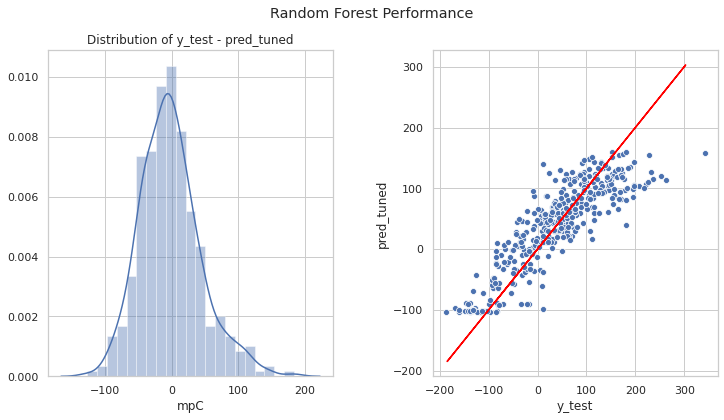

In [69]:
sns.set(style='whitegrid')

fig, axs = plt.subplots(1,2, figsize=(12, 6))

g = sns.distplot(y_test-pred_tuned, ax=axs[0])
g.set(title='Distribution of y_test - pred_tuned')
plt.plot(y_train,y_train, color='red')


h = sns.scatterplot(y_test, pred_tuned)
h.set(xlabel='y_test')
h.set(ylabel='pred_tuned')

fig.subplots_adjust(hspace=0.2, wspace=0.35)

plt.suptitle('Random Forest Performance')

plt.show()

# 7. Deep Learning Model - Keras Neural Network

In [29]:
#Can just direct copy from what we have, but we have to use the full 101 cuz RFE only applies to ML model
# General data analysis/plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Neural Net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [51]:
X = dataset_71_new.drop(['mpC'], axis=1) # features
y = dataset_71_new['mpC']

In [52]:
st = StandardScaler()
X_transform = st.fit_transform(X)

In [53]:
#Split Training and Test set into 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.25, random_state=0)

## 7.1 Building and Compiling Neural Network Model

In [54]:
# build the model!
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

# compile the model
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# early stopping callback
#es = EarlyStopping(monitor='val_loss',
                   #mode='min',
                   #patience=50,
                   #restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1000)              72000     
_________________________________________________________________
dense_17 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_18 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 251       
Total params: 698,001
Trainable params: 698,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
38/38 [==============================] - 1s 16ms/step - loss: 52.3175 - mean_absolute_error: 52.3175 - val_loss: 37.1778 - val_mean_absolute_error: 37.1778
Epoch 2/10
38/38 [==============================] - 0s 11ms/step - loss: 30.917

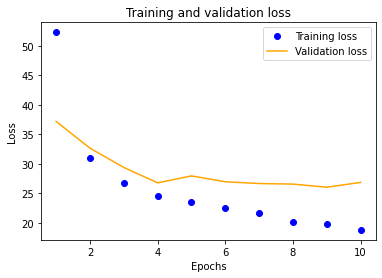

In [55]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
# prediction
y_pred = model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)

Root Mean Squared Error: 37.27914430917361
Mean Absolute Error: 26.836412032129747
R2 Score: 0.8302374964938163


## 7.2 Neural Network Hyperparameter Tuning

In [57]:
from keras.layers import Dense, Dropout

# Insert the dropout layer
model2 = Sequential()
model2.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model2.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
model2.add(Dense(500, activation='relu'))
model2.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
model2.add(Dense(250, activation='relu'))
model2.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
model2.add(Dense(1, activation='linear')) # output node
model2.summary() # see what your model looks like

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1000)              72000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 250)               125250    
_________________________________________________________________
dropout_11 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

In [58]:
# compile the model
model2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

history_tuned = model2.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Epoch 1/10
38/38 [==============================] - 1s 14ms/step - loss: 61.0388 - mean_absolute_error: 61.0388 - val_loss: 47.0185 - val_mean_absolute_error: 47.0185
Epoch 2/10
38/38 [==============================] - 0s 12ms/step - loss: 36.9635 - mean_absolute_error: 36.9635 - val_loss: 33.2734 - val_mean_absolute_error: 33.2734
Epoch 3/10
38/38 [==============================] - 0s 11ms/step - loss: 30.3836 - mean_absolute_error: 30.3836 - val_loss: 29.6666 - val_mean_absolute_error: 29.6666
Epoch 4/10
38/38 [==============================] - 0s 12ms/step - loss: 28.5752 - mean_absolute_error: 28.5752 - val_loss: 29.5188 - val_mean_absolute_error: 29.5188
Epoch 5/10
38/38 [==============================] - 0s 12ms/step - loss: 27.4719 - mean_absolute_error: 27.4719 - val_loss: 27.8165 - val_mean_absolute_error: 27.8165
Epoch 6/10
38/38 [==============================] - 0s 11ms/step - loss: 27.8776 - mean_absolute_error: 27.8776 - val_loss: 27.7087 - val_mean_absolute_error: 27.708

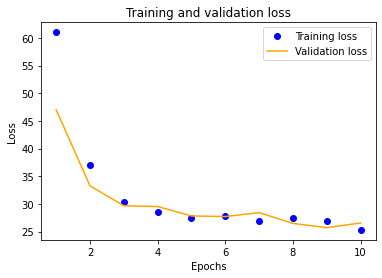

In [59]:
# let's see the training and validation accuracy by epoch
history_dict = history_tuned.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
# prediction
y_pred_tuned = model2.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2 = r2_score(y_test, y_pred_tuned)
mae = mean_absolute_error(y_test, y_pred_tuned)

print('Root Mean Squared Error:',rmse)
print('Mean Absolute Error:',mae)
print('R2 Score:',r2)

Root Mean Squared Error: 36.160139741688475
Mean Absolute Error: 26.542445583408583
R2 Score: 0.840276028185451


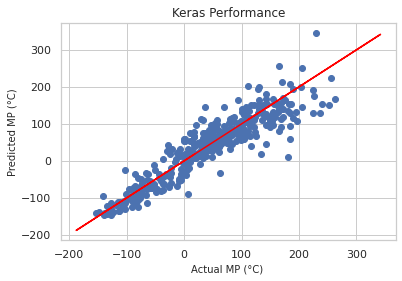

In [65]:
# scatterplot of actual vs. pred

# Validation Results
plt.scatter(x=y_test, y=model2.predict(X_test)) # first row, second entry (right top)
plt.xlabel("Actual MP (°C) ", fontsize=10)
plt.ylabel("Predicted MP (°C)",  fontsize=10)
plt.title("Keras Performance")
plt.plot(y_train,y_train, color='red')

# show the plot
plt.show()